# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:11<00:00, 5.20KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

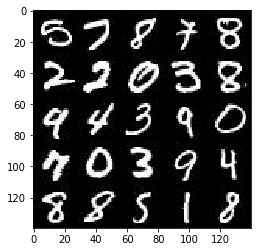

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

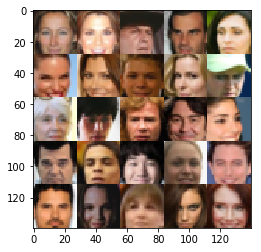

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name="input_real")
    input_z = tf.placeholder(tf.float32, shape=(None, z_dim), name="input_z")
    lr = tf.placeholder(tf.float32)

    return inputs_real, input_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope("discriminator", reuse = reuse):
        alpha = 0.2 # leaky relu parameter
        # input layer is 28x28xchannels
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', activation=None)
        relu1 = tf.maximum(alpha*x1, x1) #leaky relu
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same', activation=None)
        x2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha*x2, x2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same', activation=None)
        x3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha*x3, x3)
        # 4x4x256
        
        x4 = tf.reshape(relu3, (-1,4*4*256))
        logits = tf.layers.dense(x4, 1)
        out = tf.sigmoid(logits)
        
        

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope("generator", reuse= not is_train):
        alpha=0.2 # leaky relu parameter
        # fc layer
        x1 = tf.layers.dense(z, 4*4*512)
        x1 = tf.reshape(x1, shape=(-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1) # leaky relu
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)# leaky relu
        # 8x8x256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)# leaky relu
        # 16x16x128
        
        # Output layer
        x3 = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        logits = tf.image.resize_images(x3, (28,28)) # 28x28xout_channel
        out = tf.tanh(logits)
        
        
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    fake_img = generator(input_z, out_channel_dim, is_train=True)
    d_prob_real, d_logits_real = discriminator(input_real)
    d_prob_fake, d_logits_fake = discriminator(fake_img, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_prob_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_prob_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_prob_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, print_every=10, show_every=100):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt   = model_opt(d_loss, g_loss, learning_rate, beta1)
    saver = tf.train.Saver()
    n_images = 25
    

    samples, losses = [], []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2 # scale the images to lie b/w [-1, 1]

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(input_z, image_channels, is_train=False),
                                   feed_dict={input_z: batch_z})
                    samples.append(gen_samples)
                    show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)
                   

        saver.save(sess, './generator.ckpt')

    #with open('samples.pkl', 'wb') as f:
    #    pkl.dump(samples, f)
    
    return losses, samples
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.4366... Generator Loss: 2.6054
Epoch 1/2... Discriminator Loss: 0.3662... Generator Loss: 4.5277
Epoch 1/2... Discriminator Loss: 0.3521... Generator Loss: 5.0169
Epoch 1/2... Discriminator Loss: 1.2380... Generator Loss: 10.5549
Epoch 1/2... Discriminator Loss: 0.5108... Generator Loss: 2.8079
Epoch 1/2... Discriminator Loss: 1.3858... Generator Loss: 0.5876
Epoch 1/2... Discriminator Loss: 0.7617... Generator Loss: 1.8943
Epoch 1/2... Discriminator Loss: 1.3783... Generator Loss: 2.4620
Epoch 1/2... Discriminator Loss: 1.3130... Generator Loss: 0.6712
Epoch 1/2... Discriminator Loss: 0.7237... Generator Loss: 1.5302


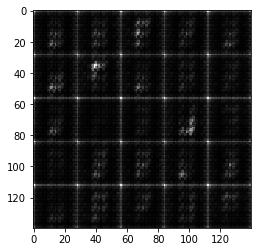

Epoch 1/2... Discriminator Loss: 0.6336... Generator Loss: 2.1512
Epoch 1/2... Discriminator Loss: 0.8473... Generator Loss: 1.3950
Epoch 1/2... Discriminator Loss: 0.7170... Generator Loss: 1.6329
Epoch 1/2... Discriminator Loss: 0.8372... Generator Loss: 2.6553
Epoch 1/2... Discriminator Loss: 0.7166... Generator Loss: 1.7842
Epoch 1/2... Discriminator Loss: 0.9931... Generator Loss: 1.0568
Epoch 1/2... Discriminator Loss: 0.9836... Generator Loss: 1.1508
Epoch 1/2... Discriminator Loss: 0.7283... Generator Loss: 1.6870
Epoch 1/2... Discriminator Loss: 1.0169... Generator Loss: 1.0387
Epoch 1/2... Discriminator Loss: 1.4526... Generator Loss: 0.6569


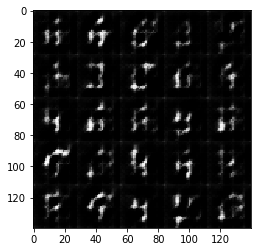

Epoch 1/2... Discriminator Loss: 1.0647... Generator Loss: 0.9663
Epoch 1/2... Discriminator Loss: 0.9819... Generator Loss: 2.5101
Epoch 1/2... Discriminator Loss: 1.2509... Generator Loss: 1.4784
Epoch 1/2... Discriminator Loss: 1.1484... Generator Loss: 0.8692
Epoch 1/2... Discriminator Loss: 1.2190... Generator Loss: 0.7091
Epoch 1/2... Discriminator Loss: 0.7917... Generator Loss: 1.8060
Epoch 1/2... Discriminator Loss: 1.0386... Generator Loss: 0.8528
Epoch 1/2... Discriminator Loss: 0.9352... Generator Loss: 1.2972
Epoch 1/2... Discriminator Loss: 1.1605... Generator Loss: 0.8020
Epoch 1/2... Discriminator Loss: 0.7950... Generator Loss: 1.4775


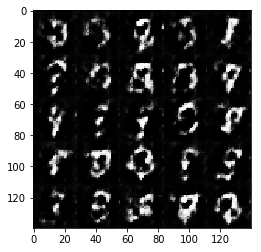

Epoch 1/2... Discriminator Loss: 0.7753... Generator Loss: 1.7368
Epoch 1/2... Discriminator Loss: 1.0330... Generator Loss: 1.8136
Epoch 1/2... Discriminator Loss: 0.9107... Generator Loss: 1.4250
Epoch 1/2... Discriminator Loss: 0.9732... Generator Loss: 1.4727
Epoch 1/2... Discriminator Loss: 0.7965... Generator Loss: 1.7346
Epoch 1/2... Discriminator Loss: 0.7529... Generator Loss: 1.8557
Epoch 1/2... Discriminator Loss: 0.8592... Generator Loss: 2.1342
Epoch 1/2... Discriminator Loss: 0.8769... Generator Loss: 1.3985
Epoch 1/2... Discriminator Loss: 0.8400... Generator Loss: 1.3927
Epoch 1/2... Discriminator Loss: 0.8379... Generator Loss: 2.0247


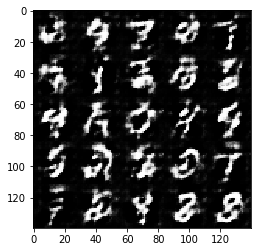

Epoch 2/2... Discriminator Loss: 1.1975... Generator Loss: 0.6662
Epoch 2/2... Discriminator Loss: 0.9020... Generator Loss: 1.2577
Epoch 2/2... Discriminator Loss: 1.1442... Generator Loss: 2.5549
Epoch 2/2... Discriminator Loss: 0.8804... Generator Loss: 1.1430
Epoch 2/2... Discriminator Loss: 1.0122... Generator Loss: 1.9332
Epoch 2/2... Discriminator Loss: 0.9450... Generator Loss: 1.7159


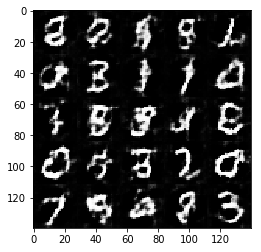

Epoch 2/2... Discriminator Loss: 1.0661... Generator Loss: 1.9141
Epoch 2/2... Discriminator Loss: 0.9834... Generator Loss: 1.9664
Epoch 2/2... Discriminator Loss: 1.2923... Generator Loss: 2.4378
Epoch 2/2... Discriminator Loss: 1.0472... Generator Loss: 0.8523
Epoch 2/2... Discriminator Loss: 0.9797... Generator Loss: 1.8353
Epoch 2/2... Discriminator Loss: 1.1036... Generator Loss: 0.7490
Epoch 2/2... Discriminator Loss: 0.9667... Generator Loss: 1.5255
Epoch 2/2... Discriminator Loss: 1.0777... Generator Loss: 0.7924
Epoch 2/2... Discriminator Loss: 1.0124... Generator Loss: 0.9661
Epoch 2/2... Discriminator Loss: 1.0134... Generator Loss: 0.8571


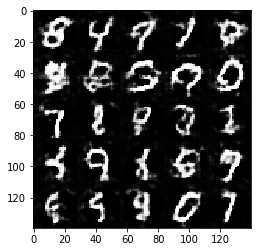

Epoch 2/2... Discriminator Loss: 0.8322... Generator Loss: 1.6715
Epoch 2/2... Discriminator Loss: 1.2680... Generator Loss: 0.5959
Epoch 2/2... Discriminator Loss: 0.9384... Generator Loss: 1.3007
Epoch 2/2... Discriminator Loss: 1.0034... Generator Loss: 0.8843
Epoch 2/2... Discriminator Loss: 1.0193... Generator Loss: 0.8848
Epoch 2/2... Discriminator Loss: 0.9120... Generator Loss: 1.5595
Epoch 2/2... Discriminator Loss: 0.9417... Generator Loss: 1.4856
Epoch 2/2... Discriminator Loss: 0.9421... Generator Loss: 1.0591
Epoch 2/2... Discriminator Loss: 0.9027... Generator Loss: 1.0609
Epoch 2/2... Discriminator Loss: 0.9980... Generator Loss: 1.6941


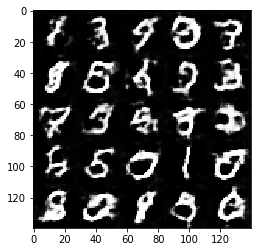

Epoch 2/2... Discriminator Loss: 0.9543... Generator Loss: 0.9737
Epoch 2/2... Discriminator Loss: 1.0851... Generator Loss: 0.7551
Epoch 2/2... Discriminator Loss: 1.0633... Generator Loss: 0.8268
Epoch 2/2... Discriminator Loss: 0.9014... Generator Loss: 1.5644
Epoch 2/2... Discriminator Loss: 1.2257... Generator Loss: 2.4897
Epoch 2/2... Discriminator Loss: 0.9600... Generator Loss: 1.0958
Epoch 2/2... Discriminator Loss: 0.9622... Generator Loss: 1.4929
Epoch 2/2... Discriminator Loss: 1.2899... Generator Loss: 0.6069
Epoch 2/2... Discriminator Loss: 0.9940... Generator Loss: 1.5546
Epoch 2/2... Discriminator Loss: 0.9763... Generator Loss: 1.6857


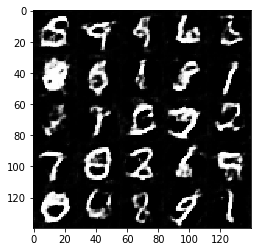

Epoch 2/2... Discriminator Loss: 0.9071... Generator Loss: 1.8011
Epoch 2/2... Discriminator Loss: 1.0348... Generator Loss: 0.9063
Epoch 2/2... Discriminator Loss: 1.0652... Generator Loss: 0.8408


In [ ]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.3175... Generator Loss: 0.6107
Epoch 1/1... Discriminator Loss: 0.7447... Generator Loss: 1.5803
Epoch 1/1... Discriminator Loss: 0.4523... Generator Loss: 3.5624
Epoch 1/1... Discriminator Loss: 0.5001... Generator Loss: 2.8760
Epoch 1/1... Discriminator Loss: 0.5354... Generator Loss: 2.3896
Epoch 1/1... Discriminator Loss: 0.9003... Generator Loss: 5.1576
Epoch 1/1... Discriminator Loss: 1.4912... Generator Loss: 1.4649
Epoch 1/1... Discriminator Loss: 1.0360... Generator Loss: 1.5121
Epoch 1/1... Discriminator Loss: 1.1019... Generator Loss: 2.5326
Epoch 1/1... Discriminator Loss: 0.9834... Generator Loss: 1.5007


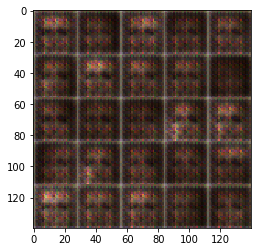

Epoch 1/1... Discriminator Loss: 1.1090... Generator Loss: 4.2462
Epoch 1/1... Discriminator Loss: 0.9566... Generator Loss: 1.1427
Epoch 1/1... Discriminator Loss: 1.0789... Generator Loss: 1.4593
Epoch 1/1... Discriminator Loss: 1.0775... Generator Loss: 1.2704
Epoch 1/1... Discriminator Loss: 1.2311... Generator Loss: 1.3122
Epoch 1/1... Discriminator Loss: 1.4443... Generator Loss: 0.6860
Epoch 1/1... Discriminator Loss: 1.3407... Generator Loss: 0.8580
Epoch 1/1... Discriminator Loss: 1.1132... Generator Loss: 1.6148
Epoch 1/1... Discriminator Loss: 1.2791... Generator Loss: 1.1241
Epoch 1/1... Discriminator Loss: 1.0003... Generator Loss: 1.7063


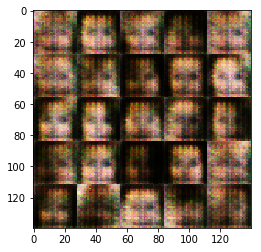

Epoch 1/1... Discriminator Loss: 1.3134... Generator Loss: 1.1033
Epoch 1/1... Discriminator Loss: 1.2903... Generator Loss: 1.0192
Epoch 1/1... Discriminator Loss: 1.9975... Generator Loss: 2.1675
Epoch 1/1... Discriminator Loss: 1.3108... Generator Loss: 1.0399
Epoch 1/1... Discriminator Loss: 1.5162... Generator Loss: 0.8176
Epoch 1/1... Discriminator Loss: 1.2710... Generator Loss: 1.1962
Epoch 1/1... Discriminator Loss: 1.1599... Generator Loss: 1.3766
Epoch 1/1... Discriminator Loss: 1.1601... Generator Loss: 1.3001
Epoch 1/1... Discriminator Loss: 1.1588... Generator Loss: 0.8802
Epoch 1/1... Discriminator Loss: 1.0510... Generator Loss: 1.0646


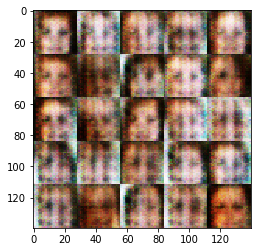

Epoch 1/1... Discriminator Loss: 1.1793... Generator Loss: 0.9913
Epoch 1/1... Discriminator Loss: 1.0474... Generator Loss: 0.9382
Epoch 1/1... Discriminator Loss: 1.2951... Generator Loss: 0.9367
Epoch 1/1... Discriminator Loss: 1.3337... Generator Loss: 1.0740
Epoch 1/1... Discriminator Loss: 1.2036... Generator Loss: 1.2149
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.9458
Epoch 1/1... Discriminator Loss: 1.3720... Generator Loss: 1.0883
Epoch 1/1... Discriminator Loss: 1.2330... Generator Loss: 1.0186
Epoch 1/1... Discriminator Loss: 1.4372... Generator Loss: 0.6711
Epoch 1/1... Discriminator Loss: 1.2519... Generator Loss: 0.8702


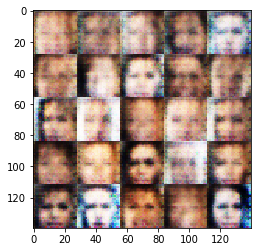

Epoch 1/1... Discriminator Loss: 1.1910... Generator Loss: 0.9078
Epoch 1/1... Discriminator Loss: 1.2147... Generator Loss: 0.9463
Epoch 1/1... Discriminator Loss: 1.3207... Generator Loss: 1.0417
Epoch 1/1... Discriminator Loss: 1.0633... Generator Loss: 1.0904
Epoch 1/1... Discriminator Loss: 1.4861... Generator Loss: 1.0042
Epoch 1/1... Discriminator Loss: 1.4923... Generator Loss: 0.8590
Epoch 1/1... Discriminator Loss: 1.4480... Generator Loss: 0.6993
Epoch 1/1... Discriminator Loss: 1.2010... Generator Loss: 0.9824
Epoch 1/1... Discriminator Loss: 1.2931... Generator Loss: 0.8803
Epoch 1/1... Discriminator Loss: 1.5816... Generator Loss: 0.9174


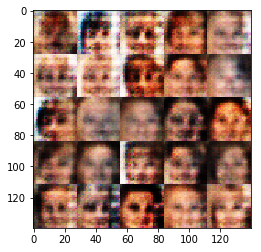

Epoch 1/1... Discriminator Loss: 1.2590... Generator Loss: 0.9599
Epoch 1/1... Discriminator Loss: 1.2998... Generator Loss: 0.8889
Epoch 1/1... Discriminator Loss: 1.2628... Generator Loss: 0.9643
Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 0.7007
Epoch 1/1... Discriminator Loss: 1.3969... Generator Loss: 0.7746
Epoch 1/1... Discriminator Loss: 1.2882... Generator Loss: 0.8094
Epoch 1/1... Discriminator Loss: 1.2134... Generator Loss: 1.0069
Epoch 1/1... Discriminator Loss: 1.3249... Generator Loss: 1.0510
Epoch 1/1... Discriminator Loss: 1.3430... Generator Loss: 0.7555
Epoch 1/1... Discriminator Loss: 1.3106... Generator Loss: 1.3118


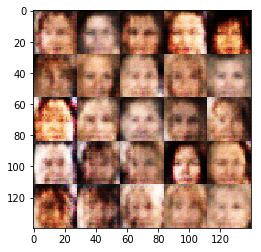

Epoch 1/1... Discriminator Loss: 1.2946... Generator Loss: 0.8699
Epoch 1/1... Discriminator Loss: 1.3048... Generator Loss: 0.6860
Epoch 1/1... Discriminator Loss: 1.4020... Generator Loss: 0.8514
Epoch 1/1... Discriminator Loss: 1.4444... Generator Loss: 0.8125
Epoch 1/1... Discriminator Loss: 1.3260... Generator Loss: 0.7003
Epoch 1/1... Discriminator Loss: 1.4097... Generator Loss: 0.9703
Epoch 1/1... Discriminator Loss: 1.3798... Generator Loss: 0.8503
Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.7291
Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 0.8286
Epoch 1/1... Discriminator Loss: 1.3505... Generator Loss: 0.8911


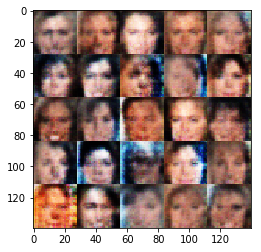

Epoch 1/1... Discriminator Loss: 1.1813... Generator Loss: 0.8739
Epoch 1/1... Discriminator Loss: 1.3178... Generator Loss: 0.8696
Epoch 1/1... Discriminator Loss: 1.2653... Generator Loss: 0.9587
Epoch 1/1... Discriminator Loss: 1.3358... Generator Loss: 0.7539
Epoch 1/1... Discriminator Loss: 1.3976... Generator Loss: 0.7939
Epoch 1/1... Discriminator Loss: 1.2156... Generator Loss: 1.0348
Epoch 1/1... Discriminator Loss: 1.1586... Generator Loss: 0.9084
Epoch 1/1... Discriminator Loss: 1.2440... Generator Loss: 0.9904
Epoch 1/1... Discriminator Loss: 1.3496... Generator Loss: 0.9974
Epoch 1/1... Discriminator Loss: 1.3381... Generator Loss: 0.9370


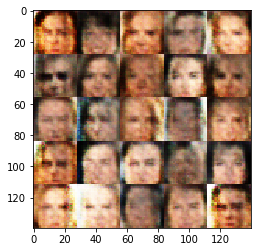

Epoch 1/1... Discriminator Loss: 1.2633... Generator Loss: 0.8991
Epoch 1/1... Discriminator Loss: 1.3437... Generator Loss: 0.7974
Epoch 1/1... Discriminator Loss: 1.1483... Generator Loss: 1.0220
Epoch 1/1... Discriminator Loss: 1.3591... Generator Loss: 1.1239
Epoch 1/1... Discriminator Loss: 1.1833... Generator Loss: 1.0038
Epoch 1/1... Discriminator Loss: 1.3961... Generator Loss: 0.6817
Epoch 1/1... Discriminator Loss: 1.2559... Generator Loss: 0.9067
Epoch 1/1... Discriminator Loss: 1.2930... Generator Loss: 0.8462
Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.7438
Epoch 1/1... Discriminator Loss: 1.2324... Generator Loss: 0.8944


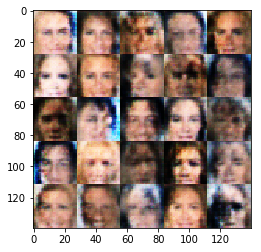

Epoch 1/1... Discriminator Loss: 1.2500... Generator Loss: 0.9465
Epoch 1/1... Discriminator Loss: 1.2593... Generator Loss: 0.9251
Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 1.0352
Epoch 1/1... Discriminator Loss: 1.3032... Generator Loss: 1.2212
Epoch 1/1... Discriminator Loss: 1.2194... Generator Loss: 0.8591
Epoch 1/1... Discriminator Loss: 1.2324... Generator Loss: 0.9227
Epoch 1/1... Discriminator Loss: 1.3487... Generator Loss: 1.0439
Epoch 1/1... Discriminator Loss: 1.2245... Generator Loss: 0.8493
Epoch 1/1... Discriminator Loss: 1.3182... Generator Loss: 0.9974
Epoch 1/1... Discriminator Loss: 1.2612... Generator Loss: 0.7841


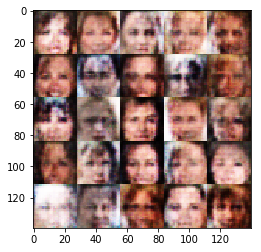

Epoch 1/1... Discriminator Loss: 1.1205... Generator Loss: 1.0554
Epoch 1/1... Discriminator Loss: 1.3254... Generator Loss: 0.8134
Epoch 1/1... Discriminator Loss: 1.2655... Generator Loss: 0.9489
Epoch 1/1... Discriminator Loss: 1.2497... Generator Loss: 0.8249
Epoch 1/1... Discriminator Loss: 1.2576... Generator Loss: 0.7332
Epoch 1/1... Discriminator Loss: 1.2363... Generator Loss: 0.8405
Epoch 1/1... Discriminator Loss: 1.3484... Generator Loss: 0.8655
Epoch 1/1... Discriminator Loss: 1.4321... Generator Loss: 0.6274
Epoch 1/1... Discriminator Loss: 1.4228... Generator Loss: 0.8784
Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.8414


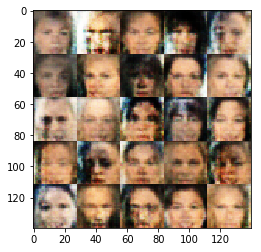

Epoch 1/1... Discriminator Loss: 1.3145... Generator Loss: 0.7923
Epoch 1/1... Discriminator Loss: 1.3043... Generator Loss: 0.6716
Epoch 1/1... Discriminator Loss: 1.2719... Generator Loss: 1.0791
Epoch 1/1... Discriminator Loss: 1.2952... Generator Loss: 0.7797
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.6952
Epoch 1/1... Discriminator Loss: 1.3678... Generator Loss: 0.8986
Epoch 1/1... Discriminator Loss: 1.1542... Generator Loss: 1.0659
Epoch 1/1... Discriminator Loss: 1.1936... Generator Loss: 1.0213
Epoch 1/1... Discriminator Loss: 1.2638... Generator Loss: 0.8886
Epoch 1/1... Discriminator Loss: 1.2993... Generator Loss: 0.7711


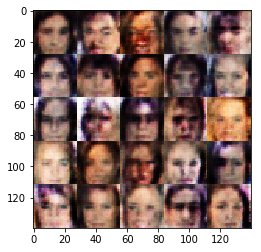

Epoch 1/1... Discriminator Loss: 1.4240... Generator Loss: 0.8062
Epoch 1/1... Discriminator Loss: 1.2435... Generator Loss: 0.8350
Epoch 1/1... Discriminator Loss: 1.2780... Generator Loss: 0.7376
Epoch 1/1... Discriminator Loss: 1.2592... Generator Loss: 1.0636
Epoch 1/1... Discriminator Loss: 1.2923... Generator Loss: 0.8846
Epoch 1/1... Discriminator Loss: 1.2234... Generator Loss: 0.8464
Epoch 1/1... Discriminator Loss: 1.3560... Generator Loss: 0.8240
Epoch 1/1... Discriminator Loss: 1.2644... Generator Loss: 1.1388
Epoch 1/1... Discriminator Loss: 1.5216... Generator Loss: 0.6844
Epoch 1/1... Discriminator Loss: 1.4247... Generator Loss: 0.8325


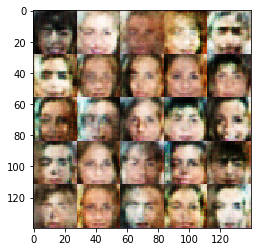

Epoch 1/1... Discriminator Loss: 1.3695... Generator Loss: 0.7574
Epoch 1/1... Discriminator Loss: 1.4061... Generator Loss: 0.8469
Epoch 1/1... Discriminator Loss: 1.2919... Generator Loss: 0.9058
Epoch 1/1... Discriminator Loss: 1.3359... Generator Loss: 0.8747
Epoch 1/1... Discriminator Loss: 1.2605... Generator Loss: 0.8650
Epoch 1/1... Discriminator Loss: 1.1908... Generator Loss: 0.9565
Epoch 1/1... Discriminator Loss: 1.2058... Generator Loss: 1.0942
Epoch 1/1... Discriminator Loss: 1.0554... Generator Loss: 1.5034
Epoch 1/1... Discriminator Loss: 1.3103... Generator Loss: 0.7406
Epoch 1/1... Discriminator Loss: 1.1981... Generator Loss: 1.0156


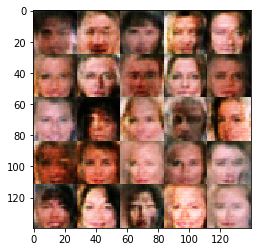

Epoch 1/1... Discriminator Loss: 1.1463... Generator Loss: 0.9689
Epoch 1/1... Discriminator Loss: 1.2452... Generator Loss: 1.0484
Epoch 1/1... Discriminator Loss: 1.3105... Generator Loss: 0.7157
Epoch 1/1... Discriminator Loss: 1.2852... Generator Loss: 0.8978
Epoch 1/1... Discriminator Loss: 1.2588... Generator Loss: 1.2549
Epoch 1/1... Discriminator Loss: 1.2230... Generator Loss: 0.7371
Epoch 1/1... Discriminator Loss: 1.4182... Generator Loss: 0.6419
Epoch 1/1... Discriminator Loss: 1.2494... Generator Loss: 1.0145
Epoch 1/1... Discriminator Loss: 1.3120... Generator Loss: 0.7347
Epoch 1/1... Discriminator Loss: 1.1427... Generator Loss: 1.3092


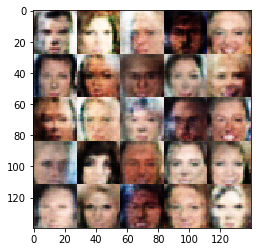

Epoch 1/1... Discriminator Loss: 1.3294... Generator Loss: 1.0429
Epoch 1/1... Discriminator Loss: 1.1240... Generator Loss: 0.8227
Epoch 1/1... Discriminator Loss: 1.2368... Generator Loss: 0.9466
Epoch 1/1... Discriminator Loss: 1.3179... Generator Loss: 0.7351
Epoch 1/1... Discriminator Loss: 1.2528... Generator Loss: 1.1803
Epoch 1/1... Discriminator Loss: 1.2831... Generator Loss: 0.7626
Epoch 1/1... Discriminator Loss: 1.3523... Generator Loss: 0.9113
Epoch 1/1... Discriminator Loss: 1.1743... Generator Loss: 0.8584
Epoch 1/1... Discriminator Loss: 1.3412... Generator Loss: 0.7352
Epoch 1/1... Discriminator Loss: 1.2826... Generator Loss: 0.7940


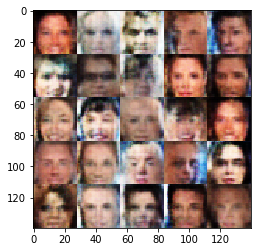

Epoch 1/1... Discriminator Loss: 1.3299... Generator Loss: 0.7905
Epoch 1/1... Discriminator Loss: 1.2518... Generator Loss: 0.9127
Epoch 1/1... Discriminator Loss: 1.2546... Generator Loss: 1.2126
Epoch 1/1... Discriminator Loss: 1.2664... Generator Loss: 0.8450
Epoch 1/1... Discriminator Loss: 1.3502... Generator Loss: 0.8913
Epoch 1/1... Discriminator Loss: 1.2047... Generator Loss: 1.0476
Epoch 1/1... Discriminator Loss: 1.3081... Generator Loss: 0.7264
Epoch 1/1... Discriminator Loss: 1.2248... Generator Loss: 0.9134
Epoch 1/1... Discriminator Loss: 1.2701... Generator Loss: 0.9445
Epoch 1/1... Discriminator Loss: 1.2497... Generator Loss: 1.1563


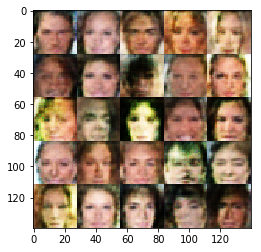

Epoch 1/1... Discriminator Loss: 1.3902... Generator Loss: 0.7586
Epoch 1/1... Discriminator Loss: 1.2780... Generator Loss: 0.7435
Epoch 1/1... Discriminator Loss: 1.2511... Generator Loss: 1.0168
Epoch 1/1... Discriminator Loss: 1.1748... Generator Loss: 0.8290
Epoch 1/1... Discriminator Loss: 1.2061... Generator Loss: 0.7882
Epoch 1/1... Discriminator Loss: 1.1855... Generator Loss: 0.9682
Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.5855
Epoch 1/1... Discriminator Loss: 1.1722... Generator Loss: 1.0043
Epoch 1/1... Discriminator Loss: 1.3222... Generator Loss: 0.6614
Epoch 1/1... Discriminator Loss: 1.2674... Generator Loss: 0.7047


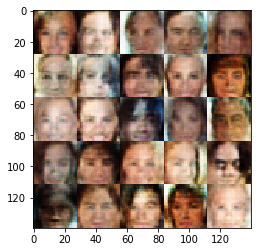

Epoch 1/1... Discriminator Loss: 1.1079... Generator Loss: 1.3895
Epoch 1/1... Discriminator Loss: 1.4173... Generator Loss: 0.6573
Epoch 1/1... Discriminator Loss: 1.3545... Generator Loss: 1.2016
Epoch 1/1... Discriminator Loss: 1.0868... Generator Loss: 1.0076
Epoch 1/1... Discriminator Loss: 1.4247... Generator Loss: 0.9659
Epoch 1/1... Discriminator Loss: 1.1864... Generator Loss: 1.1473
Epoch 1/1... Discriminator Loss: 1.3186... Generator Loss: 0.9364
Epoch 1/1... Discriminator Loss: 1.3108... Generator Loss: 1.0226
Epoch 1/1... Discriminator Loss: 1.4049... Generator Loss: 0.6156
Epoch 1/1... Discriminator Loss: 1.1600... Generator Loss: 1.0593


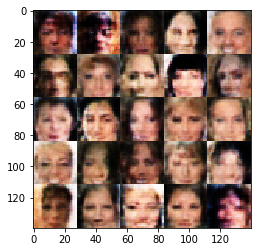

Epoch 1/1... Discriminator Loss: 1.2875... Generator Loss: 0.7353
Epoch 1/1... Discriminator Loss: 1.0925... Generator Loss: 0.9722
Epoch 1/1... Discriminator Loss: 1.2645... Generator Loss: 0.6946
Epoch 1/1... Discriminator Loss: 1.4727... Generator Loss: 0.5209
Epoch 1/1... Discriminator Loss: 1.2962... Generator Loss: 0.7221
Epoch 1/1... Discriminator Loss: 1.1827... Generator Loss: 0.8215
Epoch 1/1... Discriminator Loss: 1.3190... Generator Loss: 0.9233
Epoch 1/1... Discriminator Loss: 1.1211... Generator Loss: 1.1378
Epoch 1/1... Discriminator Loss: 1.2333... Generator Loss: 0.8489
Epoch 1/1... Discriminator Loss: 1.2349... Generator Loss: 0.7581


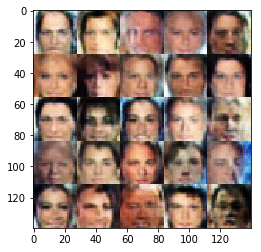

Epoch 1/1... Discriminator Loss: 1.2233... Generator Loss: 0.9100
Epoch 1/1... Discriminator Loss: 1.1822... Generator Loss: 1.0147
Epoch 1/1... Discriminator Loss: 1.1141... Generator Loss: 1.1064
Epoch 1/1... Discriminator Loss: 1.2040... Generator Loss: 0.8514
Epoch 1/1... Discriminator Loss: 1.4545... Generator Loss: 0.6724
Epoch 1/1... Discriminator Loss: 1.2576... Generator Loss: 0.8820
Epoch 1/1... Discriminator Loss: 1.2788... Generator Loss: 0.7611
Epoch 1/1... Discriminator Loss: 1.2034... Generator Loss: 0.8106
Epoch 1/1... Discriminator Loss: 1.2665... Generator Loss: 0.9959
Epoch 1/1... Discriminator Loss: 1.1493... Generator Loss: 1.1374


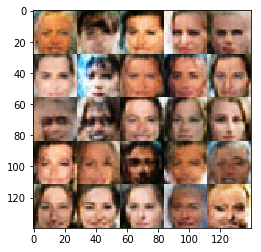

Epoch 1/1... Discriminator Loss: 1.1821... Generator Loss: 0.8896
Epoch 1/1... Discriminator Loss: 1.2308... Generator Loss: 0.8682
Epoch 1/1... Discriminator Loss: 1.3722... Generator Loss: 0.6896
Epoch 1/1... Discriminator Loss: 1.3104... Generator Loss: 0.6745
Epoch 1/1... Discriminator Loss: 1.2962... Generator Loss: 0.8576
Epoch 1/1... Discriminator Loss: 1.4127... Generator Loss: 0.7214
Epoch 1/1... Discriminator Loss: 1.2435... Generator Loss: 1.0211
Epoch 1/1... Discriminator Loss: 1.3204... Generator Loss: 0.7677
Epoch 1/1... Discriminator Loss: 1.4214... Generator Loss: 0.8549
Epoch 1/1... Discriminator Loss: 1.3658... Generator Loss: 0.6380


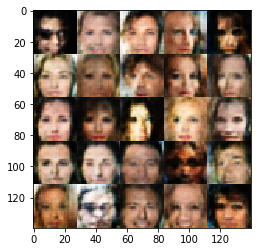

Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.7918
Epoch 1/1... Discriminator Loss: 1.2918... Generator Loss: 1.2135
Epoch 1/1... Discriminator Loss: 1.2896... Generator Loss: 0.9619
Epoch 1/1... Discriminator Loss: 1.3129... Generator Loss: 1.3420
Epoch 1/1... Discriminator Loss: 1.2560... Generator Loss: 0.7498
Epoch 1/1... Discriminator Loss: 1.2930... Generator Loss: 0.7843
Epoch 1/1... Discriminator Loss: 1.3690... Generator Loss: 0.6254
Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.7748
Epoch 1/1... Discriminator Loss: 1.2641... Generator Loss: 0.9199
Epoch 1/1... Discriminator Loss: 1.2285... Generator Loss: 0.7180


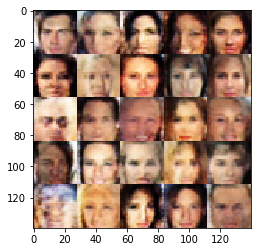

Epoch 1/1... Discriminator Loss: 1.3186... Generator Loss: 0.6869
Epoch 1/1... Discriminator Loss: 1.2454... Generator Loss: 0.9353
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.7794
Epoch 1/1... Discriminator Loss: 1.1383... Generator Loss: 1.1367
Epoch 1/1... Discriminator Loss: 1.4974... Generator Loss: 0.8045
Epoch 1/1... Discriminator Loss: 1.4919... Generator Loss: 0.5654
Epoch 1/1... Discriminator Loss: 1.1355... Generator Loss: 1.2267
Epoch 1/1... Discriminator Loss: 1.3408... Generator Loss: 0.7128
Epoch 1/1... Discriminator Loss: 1.3429... Generator Loss: 0.6329
Epoch 1/1... Discriminator Loss: 1.3171... Generator Loss: 0.7918


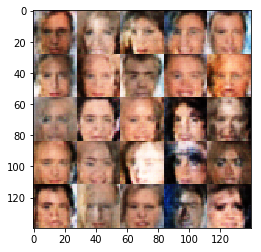

Epoch 1/1... Discriminator Loss: 1.3106... Generator Loss: 0.7265
Epoch 1/1... Discriminator Loss: 1.4090... Generator Loss: 0.6910
Epoch 1/1... Discriminator Loss: 1.1044... Generator Loss: 1.0255
Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.6913
Epoch 1/1... Discriminator Loss: 1.1844... Generator Loss: 1.1808
Epoch 1/1... Discriminator Loss: 1.0841... Generator Loss: 0.9714
Epoch 1/1... Discriminator Loss: 1.2829... Generator Loss: 0.9048
Epoch 1/1... Discriminator Loss: 1.1984... Generator Loss: 0.8560
Epoch 1/1... Discriminator Loss: 1.1599... Generator Loss: 1.0577
Epoch 1/1... Discriminator Loss: 1.0902... Generator Loss: 0.9601


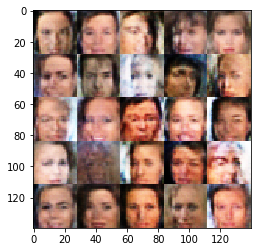

Epoch 1/1... Discriminator Loss: 1.4727... Generator Loss: 0.6820
Epoch 1/1... Discriminator Loss: 1.1936... Generator Loss: 0.9198
Epoch 1/1... Discriminator Loss: 1.1833... Generator Loss: 0.8086
Epoch 1/1... Discriminator Loss: 0.9999... Generator Loss: 1.0937
Epoch 1/1... Discriminator Loss: 1.3173... Generator Loss: 0.7698
Epoch 1/1... Discriminator Loss: 1.2732... Generator Loss: 0.9036
Epoch 1/1... Discriminator Loss: 1.2424... Generator Loss: 0.8900
Epoch 1/1... Discriminator Loss: 1.3143... Generator Loss: 0.9713
Epoch 1/1... Discriminator Loss: 1.2258... Generator Loss: 0.9249
Epoch 1/1... Discriminator Loss: 1.2132... Generator Loss: 0.9639


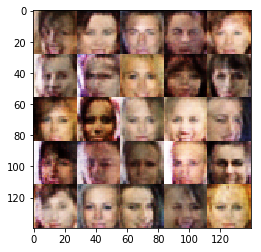

Epoch 1/1... Discriminator Loss: 1.2860... Generator Loss: 0.9447
Epoch 1/1... Discriminator Loss: 1.3403... Generator Loss: 0.9537
Epoch 1/1... Discriminator Loss: 1.2423... Generator Loss: 0.8955
Epoch 1/1... Discriminator Loss: 1.0898... Generator Loss: 1.1819
Epoch 1/1... Discriminator Loss: 1.2262... Generator Loss: 0.9539
Epoch 1/1... Discriminator Loss: 1.1623... Generator Loss: 0.9721
Epoch 1/1... Discriminator Loss: 1.2295... Generator Loss: 0.9637
Epoch 1/1... Discriminator Loss: 1.1896... Generator Loss: 0.7947
Epoch 1/1... Discriminator Loss: 1.3434... Generator Loss: 0.8931
Epoch 1/1... Discriminator Loss: 1.0423... Generator Loss: 1.1795


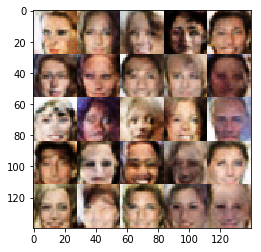

Epoch 1/1... Discriminator Loss: 1.3377... Generator Loss: 0.6945
Epoch 1/1... Discriminator Loss: 1.2478... Generator Loss: 0.8637
Epoch 1/1... Discriminator Loss: 1.1879... Generator Loss: 0.9796
Epoch 1/1... Discriminator Loss: 1.2751... Generator Loss: 1.2646
Epoch 1/1... Discriminator Loss: 1.2836... Generator Loss: 0.8792
Epoch 1/1... Discriminator Loss: 1.1105... Generator Loss: 0.9955
Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 0.7795
Epoch 1/1... Discriminator Loss: 1.2045... Generator Loss: 0.8868
Epoch 1/1... Discriminator Loss: 1.4831... Generator Loss: 0.5954
Epoch 1/1... Discriminator Loss: 1.0801... Generator Loss: 1.0500


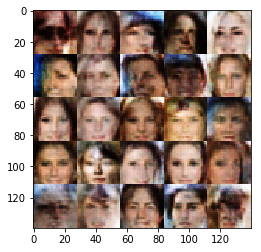

Epoch 1/1... Discriminator Loss: 1.2891... Generator Loss: 0.8649
Epoch 1/1... Discriminator Loss: 1.2587... Generator Loss: 0.9188
Epoch 1/1... Discriminator Loss: 1.3494... Generator Loss: 0.6211
Epoch 1/1... Discriminator Loss: 1.1616... Generator Loss: 0.8111
Epoch 1/1... Discriminator Loss: 1.0576... Generator Loss: 1.0082
Epoch 1/1... Discriminator Loss: 1.1562... Generator Loss: 1.1068
Epoch 1/1... Discriminator Loss: 1.1662... Generator Loss: 0.9712
Epoch 1/1... Discriminator Loss: 1.1931... Generator Loss: 0.9112
Epoch 1/1... Discriminator Loss: 1.2919... Generator Loss: 0.7019
Epoch 1/1... Discriminator Loss: 1.2039... Generator Loss: 0.7815


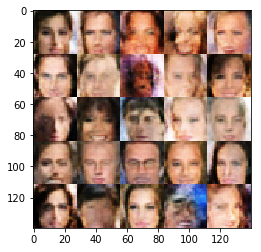

Epoch 1/1... Discriminator Loss: 1.3500... Generator Loss: 0.6705
Epoch 1/1... Discriminator Loss: 1.0479... Generator Loss: 1.0005
Epoch 1/1... Discriminator Loss: 1.2974... Generator Loss: 0.8084
Epoch 1/1... Discriminator Loss: 1.1722... Generator Loss: 0.8914
Epoch 1/1... Discriminator Loss: 1.1296... Generator Loss: 0.8903
Epoch 1/1... Discriminator Loss: 1.1846... Generator Loss: 0.9277
Epoch 1/1... Discriminator Loss: 1.1794... Generator Loss: 0.9236
Epoch 1/1... Discriminator Loss: 1.1474... Generator Loss: 0.9892
Epoch 1/1... Discriminator Loss: 1.1015... Generator Loss: 0.9236
Epoch 1/1... Discriminator Loss: 1.2982... Generator Loss: 0.6595


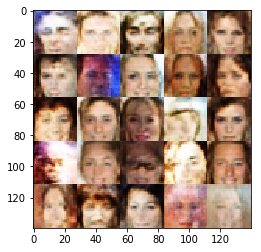

Epoch 1/1... Discriminator Loss: 1.1598... Generator Loss: 1.0980
Epoch 1/1... Discriminator Loss: 1.2613... Generator Loss: 0.6323
Epoch 1/1... Discriminator Loss: 1.2387... Generator Loss: 0.8377
Epoch 1/1... Discriminator Loss: 1.1858... Generator Loss: 0.9346
Epoch 1/1... Discriminator Loss: 1.3188... Generator Loss: 0.8987
Epoch 1/1... Discriminator Loss: 1.2307... Generator Loss: 0.9590
Epoch 1/1... Discriminator Loss: 1.1906... Generator Loss: 1.0114
Epoch 1/1... Discriminator Loss: 1.2126... Generator Loss: 0.9540
Epoch 1/1... Discriminator Loss: 1.4154... Generator Loss: 0.8411
Epoch 1/1... Discriminator Loss: 1.2103... Generator Loss: 0.7304


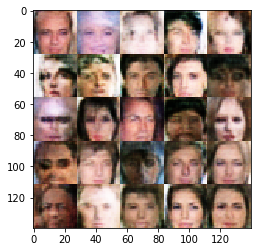

Epoch 1/1... Discriminator Loss: 1.2210... Generator Loss: 0.7057
Epoch 1/1... Discriminator Loss: 1.2366... Generator Loss: 1.5321
Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.6860
Epoch 1/1... Discriminator Loss: 1.2588... Generator Loss: 0.8078
Epoch 1/1... Discriminator Loss: 1.2809... Generator Loss: 0.7479
Epoch 1/1... Discriminator Loss: 1.1145... Generator Loss: 1.1097


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.